Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/15: 100%|██████████| 9195/9195 [01:47<00:00, 85.18it/s, BatchLoss=0.000603]


Epoch 1/15 | Train Loss: 0.0174 | Val Loss: 0.0011


Epoch 2/15: 100%|██████████| 9195/9195 [01:47<00:00, 85.25it/s, BatchLoss=0.000569]


Epoch 2/15 | Train Loss: 0.0016 | Val Loss: 0.0010


Epoch 3/15: 100%|██████████| 9195/9195 [01:47<00:00, 85.72it/s, BatchLoss=0.000966]


Epoch 3/15 | Train Loss: 0.0012 | Val Loss: 0.0012


Epoch 4/15: 100%|██████████| 9195/9195 [01:48<00:00, 84.91it/s, BatchLoss=0.00127]


Epoch 4/15 | Train Loss: 0.0010 | Val Loss: 0.0009


Epoch 5/15: 100%|██████████| 9195/9195 [01:48<00:00, 84.78it/s, BatchLoss=0.000161]


Epoch 5/15 | Train Loss: 0.0010 | Val Loss: 0.0008


Epoch 6/15: 100%|██████████| 9195/9195 [01:49<00:00, 84.15it/s, BatchLoss=0.000666]


Epoch 6/15 | Train Loss: 0.0009 | Val Loss: 0.0009


Epoch 7/15: 100%|██████████| 9195/9195 [01:47<00:00, 85.41it/s, BatchLoss=0.0018]


Epoch 7/15 | Train Loss: 0.0009 | Val Loss: 0.0008


Epoch 8/15: 100%|██████████| 9195/9195 [01:48<00:00, 84.58it/s, BatchLoss=0.00125]


Epoch 8/15 | Train Loss: 0.0009 | Val Loss: 0.0008


Epoch 9/15: 100%|██████████| 9195/9195 [01:47<00:00, 85.57it/s, BatchLoss=0.000494]


Epoch 9/15 | Train Loss: 0.0009 | Val Loss: 0.0008


Epoch 10/15: 100%|██████████| 9195/9195 [01:48<00:00, 84.53it/s, BatchLoss=0.000725]


Epoch 10/15 | Train Loss: 0.0009 | Val Loss: 0.0008


Epoch 11/15: 100%|██████████| 9195/9195 [01:47<00:00, 85.28it/s, BatchLoss=0.000257]


Epoch 11/15 | Train Loss: 0.0009 | Val Loss: 0.0008


Epoch 12/15: 100%|██████████| 9195/9195 [01:49<00:00, 84.29it/s, BatchLoss=0.000583]


Epoch 12/15 | Train Loss: 0.0009 | Val Loss: 0.0008


Epoch 13/15: 100%|██████████| 9195/9195 [01:48<00:00, 84.86it/s, BatchLoss=0.000186]


Epoch 13/15 | Train Loss: 0.0009 | Val Loss: 0.0008


Epoch 14/15: 100%|██████████| 9195/9195 [01:48<00:00, 84.69it/s, BatchLoss=0.00111]


Epoch 14/15 | Train Loss: 0.0009 | Val Loss: 0.0008


Epoch 15/15: 100%|██████████| 9195/9195 [01:48<00:00, 85.06it/s, BatchLoss=0.000953]


Epoch 15/15 | Train Loss: 0.0009 | Val Loss: 0.0008


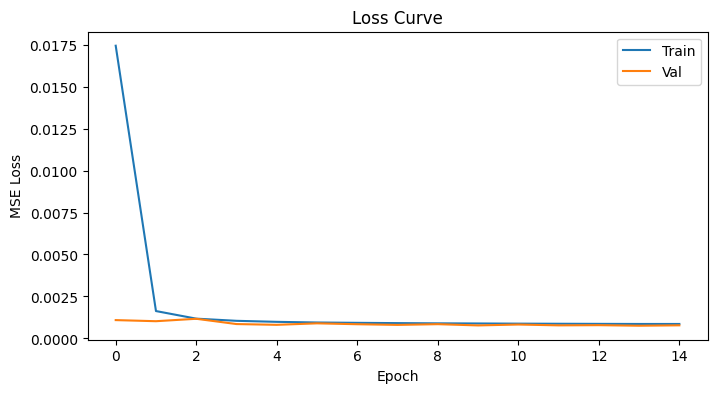

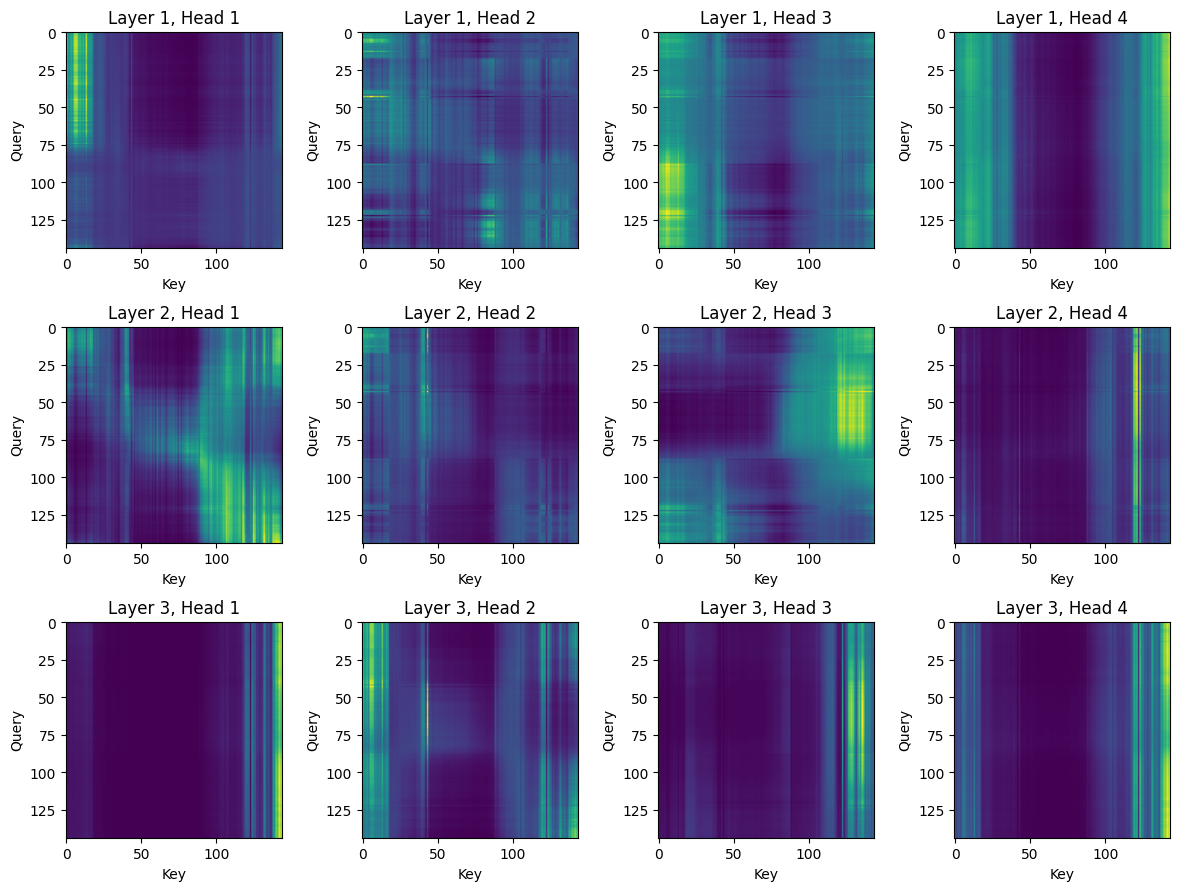

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive')
os.chdir('/content/drive/My Drive/lxy')
features = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
            'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
            'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
dataframe = pd.read_csv("jena_climate_2009_2016.csv", index_col=0)
data = dataframe[features].values
mean = data.mean(axis=0)
std = data.std(axis=0)
data = (data - mean) / std

seq_len = 144  # 24hours，10min interval
X, y = [], []
for i in range(len(data) - seq_len):
    X.append(data[i:i + seq_len])
    y.append(data[i + seq_len][1])  # 'T (degC)'
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

n = len(X)
split1 = int(0.7 * n)
split2 = int(0.9 * n)
X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

batch_size = 32
train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(SequenceDataset(X_val, y_val), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Time2Vec Positional Encoding
class Time2Vec(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.periodic = nn.Linear(input_dim, output_dim - 1)
    def forward(self, x):
        linear_part = self.linear(x)
        periodic_part = torch.sin(self.periodic(x))
        return torch.cat([linear_part, periodic_part], dim=-1)


class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, ff_dim, num_layers, seq_len,
                 use_time2vec=True, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.use_time2vec = use_time2vec
        self.pos_encoder = Time2Vec(model_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Sequential(
            nn.Linear(model_dim, model_dim//2),
            nn.ReLU(),
            nn.Linear(model_dim//2, 1)
        )
    def forward(self, x):
        x = self.input_proj(x)
        if self.use_time2vec:
            x = x + self.pos_encoder(x)
        else:
            x = self.pos_encoder(x)
        out = self.transformer_encoder(x)
        pred = self.fc_out(out[:, -1, :]).squeeze(-1)
        return pred


    def forward_with_attention(self, x):
            x = self.input_proj(x)
            if self.use_time2vec:
                x = x + self.pos_encoder(x)
            else:
                x = self.pos_encoder(x)
            attn_weights_all = []
            attn_output = x
            for encoder_layer in self.transformer_encoder.layers:
                attn_output, attn_weights = encoder_layer.self_attn(
                    attn_output, attn_output, attn_output, need_weights=True, average_attn_weights=False
                )

                attn_weights_all.append(attn_weights.detach().cpu())
                attn_output = encoder_layer.dropout1(attn_output)
                attn_output = encoder_layer.norm1(attn_output + x)
                attn_output = encoder_layer.linear2(encoder_layer.dropout(encoder_layer.activation(encoder_layer.linear1(attn_output))))
                attn_output = encoder_layer.dropout2(attn_output)
                attn_output = encoder_layer.norm2(attn_output + x)
            pred = self.fc_out(attn_output[:, -1, :]).squeeze(-1)
            return pred, attn_weights_all


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss Curve')
    plt.show()


def plot_all_attention_maps(attn_weights_all, sample_idx=0, seq_len=144):
    n_layers = len(attn_weights_all)
    n_heads = attn_weights_all[0].shape[1]
    fig, axes = plt.subplots(n_layers, n_heads, figsize=(3*n_heads, 3*n_layers))
    for layer in range(n_layers):
        attn_weights = attn_weights_all[layer]  # shape: (batch, num_heads, seq_len, seq_len)
        for head in range(n_heads):
            attn = attn_weights[sample_idx, head, :seq_len, :seq_len].numpy()
            ax = axes[layer, head] if n_layers > 1 else axes[head]
            im = ax.imshow(attn, cmap='viridis')
            ax.set_title(f"Layer {layer+1}, Head {head+1}")
            ax.set_xlabel('Key')
            ax.set_ylabel('Query')
    plt.tight_layout()
    plt.show()

input_dim = len(features)
model_dim = 32
model = TransformerEncoderModel(
    input_dim=input_dim, model_dim=model_dim, num_heads=4, ff_dim=64, num_layers=3,
    seq_len=seq_len, use_time2vec=True
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()


max_epochs = 15
train_losses, val_losses = [], []
for epoch in range(max_epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}")
    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        pbar.set_postfix({'BatchLoss': loss.item()})
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# loss
plot_losses(train_losses, val_losses)

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred, attn_weights_all = model.forward_with_attention(xb)
        # attn_weights_all: list of (batch, num_heads, seq_len, seq_len)
        plot_all_attention_maps(attn_weights_all, sample_idx=0, seq_len=seq_len)
        break

